# U.S. Medical Insurance Costs

## Data Parsing
We have a csv file with insurance costs in the U.S., containing age, bmi, sex, number of children, smoker status, and geographical region. The following blocks of code load the data and saves it to relevant variables. 

`insurance_data` contains all of the csv data as a dictionary, with the key being the id (row index).
`ages`, `bmis`, `sexes`, `children_nums`, `smokers`, `regions`, and `costs` are all Numpy arrays containing the related data in the same order.

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
insurance_data = {}

with open('insurance.csv') as insurance_csv:
    insurance_dict_reader = csv.DictReader(insurance_csv)
    for i, row in enumerate(insurance_dict_reader):
        insurance_data[i] = row  # The row number becomes the id.

print(f'Index 0 data: {insurance_data[0]}')
print(f'There are {len(insurance_data.keys())} datapoints in this dataset')

Index 0 data: {'age': '19', 'sex': 'female', 'bmi': '27.9', 'children': '0', 'smoker': 'yes', 'region': 'southwest', 'charges': '16884.924'}
There are 1338 datapoints in this dataset


In [3]:
# Initialize the data variables as empty lists.
ages = []
bmis = []
sexes = []
children_nums = []
smokers = []
regions = []
costs = []

# Add the data to each list.
for idx in range(len(insurance_data.keys())):
    ages.append(insurance_data[idx]['age'])
    bmis.append(insurance_data[idx]['bmi'])
    sexes.append(insurance_data[idx]['sex'])
    children_nums.append(insurance_data[idx]['children'])
    smokers.append(insurance_data[idx]['smoker'])
    regions.append(insurance_data[idx]['region'])
    costs.append(insurance_data[idx]['charges'])
    
# Convert data variables to Numpy arrays.
ages = np.array(ages, dtype=float)
bmis = np.array(bmis, dtype=float)
sexes = np.array(sexes)
children_nums = np.array(children_nums)
smokers = np.array(smokers)
regions = np.array(regions)
costs = np.array(costs)

print(f'First 10 ages: {ages[:10]}')

First 10 ages: [19. 18. 28. 33. 32. 31. 46. 37. 37. 60.]


## Linear Regression

In [4]:
def get_y(m, b, x):
    return m * x + b

In [5]:
def get_error(m, b, points):
    points_x = points[:, 0]
    points_y = points[:, 1]
    return np.abs(points_y - get_y(m, b, points_x))

In [6]:
def linear_regression(ms, bs, points):
    m_best = 0
    b_best = 0
    error = float('inf')
    for m in ms:
        for b in bs:
            if error < get_error(m, b, points).mean():
                continue
            error = get_error(m, b, points).mean()
            m_best = m
            b_best = b
    return m_best, b_best

In [7]:
def get_range_array(center, tolerance_percent=0.1, steps=100):
    if abs(center) > 10:
        start = center * (1 - tolerance_percent)
        stop = center * (1 + tolerance_percent)
    else:
        start = center - tolerance_percent * steps / 2
        stop = center + tolerance_percent * steps / 2
    increment = (stop - start) / steps
    return np.arange(start, stop+increment, increment)

In [8]:
def run_linear_regressions(points, initial_m=250., initial_b=3000.):
    m_best = initial_m
    b_best = initial_b
    for tolerance in [1e1, 1e0, 1e-1, 1e-2, 1e-3]:
        m_range = get_range_array(m_best, tolerance)
        b_range = get_range_array(b_best, tolerance)
        m_best, b_best = linear_regression(m_range, b_range, points)
        
        # Recenter if any of values are at the edges
        move_counter = 0
        while m_best in [m_range.min(), m_range.max()] or b_best in [b_range.min(), b_range.max()]:
            m_range = get_range_array(m_best, tolerance)
            b_range = get_range_array(b_best, tolerance)
            m_best, b_best = linear_regression(m_range, b_range, points)
            move_counter += 1
            if move_counter > 100:
                break
    return m_best, b_best

In [9]:
def get_unique_and_significant_values(values):
    values_unique, values_counts = np.unique(values, return_counts=True)
    # Values are significant if they represent more than 1% of the data (13 datapoints)
    values_significant = np.array([unique for unique, count in zip(values_unique, values_counts)
                                   if count > len(values) * 0.01])
    return values_unique, values_significant

## Age Analysis

In [10]:
print(f'Average age: {ages.mean()}')

Average age: 39.20702541106129


In [11]:
# Find the unique ages, and then calculate the average cost per unique age
ages_unique, ages_significant = get_unique_and_significant_values(ages)
avg_cost_per_age = np.array([np.array(costs[ages==i], dtype=float).mean() for i in ages_significant])
ages_costs = np.stack([ages_significant, avg_cost_per_age], axis=-1)

In [12]:
m_age, b_age = run_linear_regressions(ages_costs, 10000, 3000)
print(m_age, b_age, get_error(m_age, b_age, ages_costs).mean())

253.46636682595246 3079.635454108041 1816.387347274485


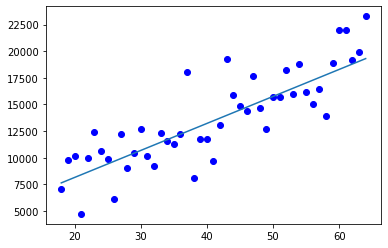

In [13]:
# From the linear regression, we got m=253.5 and b=3078.5. Here, we'll plot that
predicted_ys = get_y(m_age, b_age, ages_costs[:, 0])
plt.plot(ages_costs[:, 0], ages_costs[:, 1], 'bo', ages_costs[:, 0], predicted_ys)
plt.show()

## BMI Analysis

In [14]:
print(f'Average BMI: {bmis.mean()}')

Average BMI: 30.66339686098655


In [15]:
bmis_rounded = np.around(bmis)
bmis_unique, bmis_significant = get_unique_and_significant_values(bmis_rounded)
avg_cost_per_bmi = np.array([np.array(costs[bmis_rounded==i], dtype=float).mean() for i in bmis_significant])
bmis_costs = np.stack([bmis_significant, avg_cost_per_bmi], axis=-1)

In [16]:
m_bmi, b_bmi = run_linear_regressions(bmis_costs)
print(m_bmi, b_bmi, get_error(m_bmi, b_bmi, bmis_costs).mean())

463.89138985739936 -565.0329577765034 1516.4790442122558


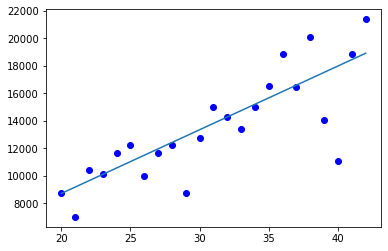

In [17]:
# Plot the results of the linear regression
predicted_ys = get_y(m_bmi, b_bmi, bmis_costs[:, 0])
plt.plot(bmis_costs[:, 0], bmis_costs[:, 1], 'bo', bmis_costs[:, 0], predicted_ys)
plt.show()